In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

from nltk import word_tokenize, ngrams
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))



In [3]:
quora = pd.read_csv('quora_duplicate_questions.tsv', sep='\t')

In [4]:
pd.set_option('display.max_colwidth', -1)
quora.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [5]:
quora.shape

(404290, 6)

In [6]:
(len(quora[quora['is_duplicate'] == 1])/quora.shape[0])*100

36.9197853026293

In [7]:
quora[quora['question2'] == 'What is the solution for this question?']

,id,qid1,qid2,question1,question2,is_duplicate
4662,4662,9209,9210,What is the solution to this question?,What is the solution for this question?,0


In [8]:
(len(quora[quora['is_duplicate'] == 0])/quora.shape[0])*100

63.08021469737069

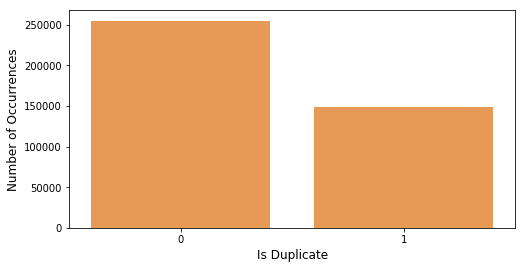

In [9]:
# target variable distribution
is_dup = quora['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=pal[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.show()

In [10]:
train_qs = pd.Series(quora['question1'].tolist() + quora['question2'].tolist()).astype(str)

In [11]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [12]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [13]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [35]:
import gensim
from gensim.models import Word2Vec
    
model = gensim.models.KeyedVectors.load_word2vec_format('./word2vec-GoogleNews-vectors-master/GoogleNews-vectors-negative300.bin.gz', binary=True)

OSError: Not a gzipped file (b've')

In [14]:
import difflib

In [16]:
def diff_ratios(ques1, ques2):
    match = difflib.SequenceMatcher()
    match.set_seqs(str(ques1).lower(), str(ques2).lower())
    return match.ratio()

In [15]:
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [28]:
c = quora.apply(word_match_share, axis=1, raw=True)
import numpy as np
print((np.array(c) > 0.5).astype(int))

[1 0 0 ... 0 0 1]


In [17]:
quora.apply(lambda r: diff_ratios(r.question1, r.question2), axis=1)  

0         0.926829
1         0.661871
2         0.439394
3         0.086957
4         0.365217
5         0.681818
6         0.222222
7         0.619718
8         0.852941
9         0.495413
10        0.184971
11        0.765432
12        0.880000
13        0.938272
14        0.967972
15        0.532609
16        0.982456
17        0.412371
18        0.593548
19        0.894737
20        0.637681
21        0.447059
22        0.809524
23        0.098765
24        0.425197
25        0.928571
26        0.774194
27        0.269663
28        0.911392
29        0.654206
            ...   
404260    0.472222
404261    0.704918
404262    0.821918
404263    0.580153
404264    0.416667
404265    0.515152
404266    0.168776
404267    0.772727
404268    0.288462
404269    0.730435
404270    0.840909
404271    0.386207
404272    0.576471
404273    0.661538
404274    0.513274
404275    0.460432
404276    0.680000
404277    0.654545
404278    0.752688
404279    0.545455
404280    0.905660
404281    0.

C:\Users\koour\Miniconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\koour\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\koour\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'word_match_share')

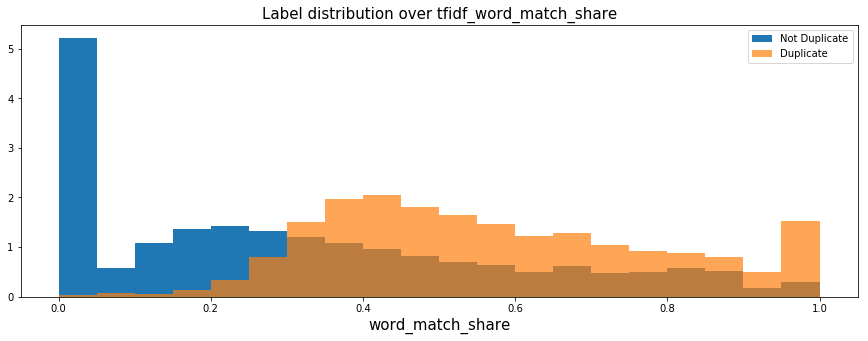

In [38]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = quora.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[quora['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[quora['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)


In [40]:
quora.sample(5)


,id,qid1,qid2,question1,question2,is_duplicate
300161,300161,422914,422915,Do you think Kohli is over-rated than Pujara and Rahane in test matches?,Which is the best out of syllabus science books for class 10th student?,0
382161,382161,45161,513979,What are some of the mind-blowing operations of India's intelligence agency RAW?,What are some of the mind blowing operations of Pakistan's intelligence agency ISI?,0
335268,335268,311249,147738,How can you get rid of detergent stains on clothes?,What are some ways to get rid of laundry detergent stains?,1
355627,355627,484873,484874,How do find people who would let me work on their short films in London?,Where can I find production assistant work on short films and music videos in London?,1
345109,345109,261022,473400,Which one is better Nexus 6p or oneplus 3?,Which one is better: Nexus 5x or Oneplus 2?,0


In [11]:
quora[pd.isnull(quora).any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English name is most suitable for me considering the pronounciation of my Chinese name?,0


In [12]:
quora['is_duplicate'].mean()*100

36.9197853026293

In [41]:
quora_qs = pd.Series(quora['question1'].tolist() + quora['question2'].tolist()).astype(str)

In [42]:
dist_quora = quora_qs.apply(len)

In [43]:
dist_quora.mean()

59.82254817086745

Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780


Text(0, 0.5, 'Number of total questions')

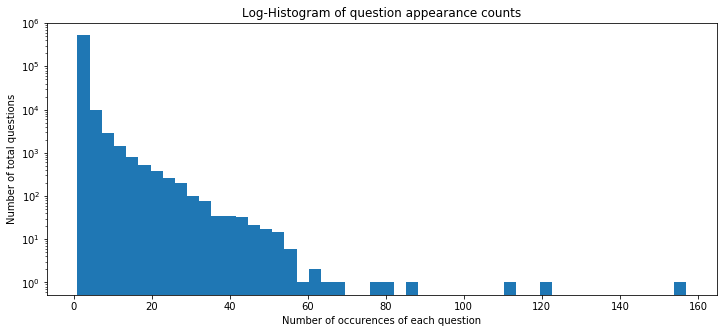

In [39]:
# Question appearance count
qids = pd.Series(quora['qid1'].tolist() + quora['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log')
# nonposy='clip'
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of each question')
plt.ylabel('Number of total questions')


In [17]:
(111780/537933)*100

20.77953945937505

C:\Users\koour\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


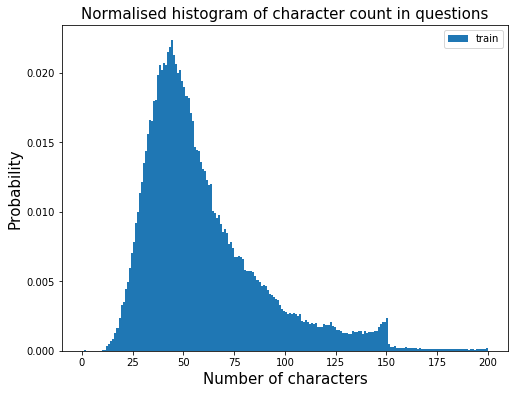

In [50]:
# Character count
plt.figure(figsize=(8, 6))
plt.hist(dist_quora, bins=200, range=[0, 200], normed=True, label='train')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()


In [19]:
print('mean-train {:.2f} \nstd-train {:.2f} \nmax-train {:.2f} '.format(dist_quora.mean(), 
                          dist_quora.std(), dist_quora.max()))

mean-train 59.82 
std-train 31.96 
max-train 1169.00 


In [48]:
# number of words count
dist_quora_words = quora_qs.apply(lambda x: len(x.split(' ')))

C:\Users\koour\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


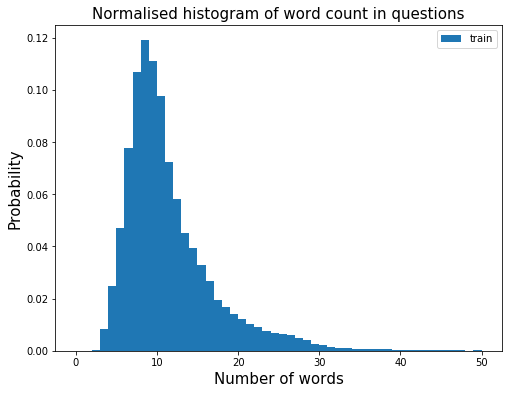

In [51]:
# word count
plt.figure(figsize=(8, 6))
plt.hist(dist_quora_words, bins=50, range=[0, 50], normed=True, label='train')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()


In [52]:
print('mean-train = {:.2f} \nstd-train = {:.2f} \nmax-train = {:.2f} '.format(dist_quora_words.mean(), 
                          dist_quora_words.std(), dist_quora_words.max()))

mean-train = 11.06 
std-train = 5.89 
max-train = 237.00 


(-0.5, 499.5, 299.5, -0.5)

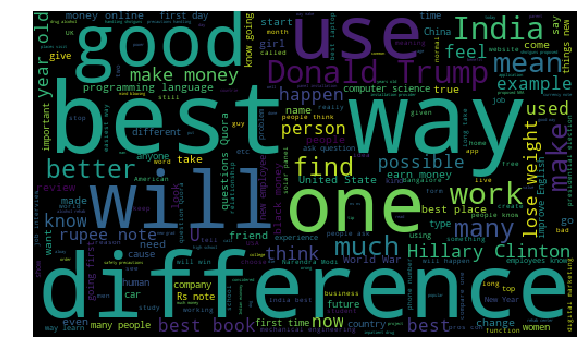

In [54]:
from wordcloud import WordCloud
cloud = WordCloud(width=500, height=300).generate(" ".join(quora_qs.astype(str)))
plt.figure(figsize=(10, 6))
plt.imshow(cloud)
plt.axis('off')


In [23]:
print(dist_quora_words)

0         14
1         8 
2         14
3         11
4         13
5         16
6         4 
7         7 
8         8 
9         9 
10        9 
11        9 
12        7 
13        7 
14        29
15        15
16        4 
17        12
18        14
19        9 
20        5 
21        6 
22        9 
23        7 
24        17
25        14
26        4 
27        8 
28        8 
29        8 
         .. 
808550    9 
808551    12
808552    7 
808553    11
808554    10
808555    7 
808556    33
808557    15
808558    9 
808559    10
808560    8 
808561    12
808562    14
808563    16
808564    9 
808565    15
808566    3 
808567    5 
808568    10
808569    16
808570    11
808571    13
808572    6 
808573    12
808574    8 
808575    13
808576    9 
808577    3 
808578    25
808579    10
Length: 808580, dtype: int64


In [21]:
qmarks = np.mean(quora_qs.apply(lambda x: '?' in x))
math = np.mean(quora_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(quora_qs.apply(lambda x: '.' in x))
capital_first = np.mean(quora_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(quora_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(quora_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


C:\Users\koour\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\koour\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'word_match_share')

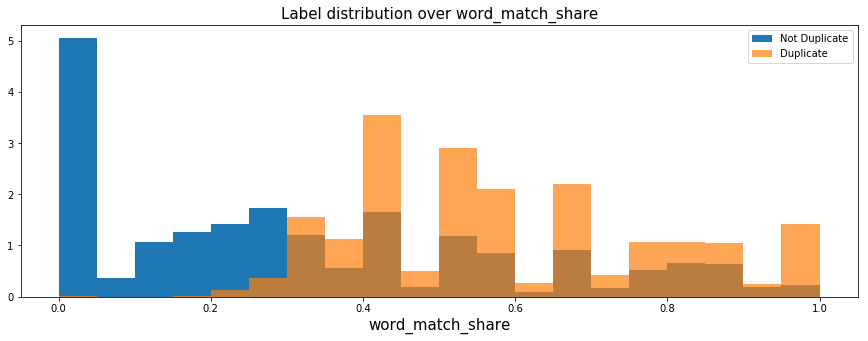

In [22]:


def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
#     shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1)*2)/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
quora_word_match = quora.apply(word_match_share, axis=1, raw=True)
plt.hist(quora_word_match[quora['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(quora_word_match[quora['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [23]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(quora_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [24]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [25]:
# common words distribution
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in stops]

def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )

def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

quora["unigrams_ques1"] = quora['question1'].apply(lambda x: get_unigrams(str(x)))
quora["unigrams_ques2"] = quora['question2'].apply(lambda x: get_unigrams(str(x)))
quora["unigrams_common_count"] = quora.apply(lambda row: get_common_unigrams(row),axis=1)
quora["unigrams_common_ratio"] = quora.apply(lambda row: get_common_unigram_ratio(row), axis=1)

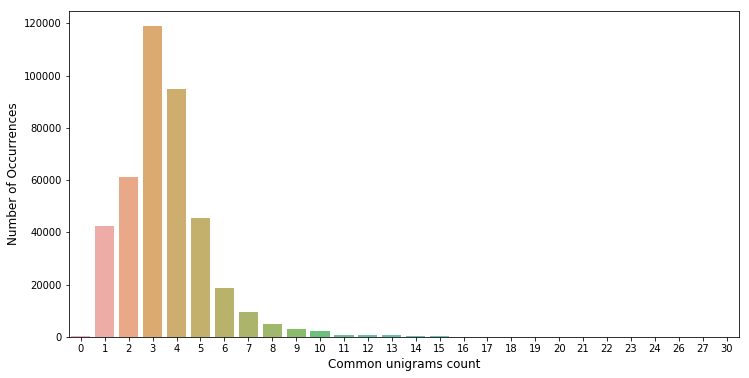

In [26]:
cnt_srs = quora['unigrams_common_count'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Common unigrams count', fontsize=12)
plt.show()

In [27]:
from collections import defaultdict
q_dict = defaultdict(set)
ques = pd.concat([quora[['question1', 'question2']]], axis=0).reset_index(drop='index')
for i in range(ques.shape[0]):
    q_dict[ques.question1[i]].add(ques.question2[i])
    q_dict[ques.question2[i]].add(ques.question1[i])
    



In [28]:
print(ques[0:5])


                                                                      question1  \
0  What is the step by step guide to invest in share market in india?             
1  What is the story of Kohinoor (Koh-i-Noor) Diamond?                            
2  How can I increase the speed of my internet connection while using a VPN?      
3  Why am I mentally very lonely? How can I solve it?                             
4  Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?   

                                                                                  question2  
0  What is the step by step guide to invest in share market?                                 
1  What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?  
2  How can Internet speed be increased by hacking through DNS?                               
3  Find the remainder when [math]23^{24}[/math] is divided by 24,23?                         
4  Which fish would survive in 

In [29]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n_items = take(10, q_dict.items())

In [30]:
n_items

[('What is the step by step guide to invest in share market in india?',
  {'What is the step by step guide to invest in share market?'}),
 ('What is the step by step guide to invest in share market?',
  {'What is the step by step guide to invest in share market in india?'}),
 ('What is the story of Kohinoor (Koh-i-Noor) Diamond?',
  {'Could India keep the Koh-I-Noor safe?',
   'Is it possible to melt down diamonds?',
   'What are some interesting facts about Kohinoor diamond?',
   'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?'}),
 ('What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?',
  {'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
   "Why can't India get its Kohinoor diamond back?"}),
 ('How can I increase the speed of my internet connection while using a VPN?',
  {'How can Internet speed be increased by hacking through DNS?'}),
 ('How can Internet speed be increased by hacking through DNS?',
 

In [39]:
ques = quora[['question1', 'question2']].reset_index(drop='index')
ques.shape

(404290, 2)

In [40]:
from collections import defaultdict
q_dict = defaultdict(set)
for i in range(ques.shape[0]):
        q_dict[ques.question1[i]].add(ques.question2[i])
        q_dict[ques.question2[i]].add(ques.question1[i])

In [42]:
len(q_dict)

537361

In [25]:
ques

NameError: name 'ques' is not defined